# Tutorial 03: Physics-based Pattern Generation Using LPF Framework

## Introduction

This tutorial demonstrates how to generate ladybird patterns using the **LPF** with PDE parameters from the LadybirdMNIST datset.

### What This Tutorial Covers

1. Loading Model Configurations
    - Extract PDE parameters from the `models` configuration
    - Parse JSON-formatted model specifications
    - Understand parameter meanings and their effects on patterns

2. **Setting Up LPF Simulations**
   - Initialize reaction-diffusion solvers with dataset parameters
   - Configure domain specifications and boundary conditions
   - Set appropriate time steps and iteration counts

3. **Pattern Generation Process**
   - Run reaction-diffusion simulations
   - Monitor convergence and stability
   - Generate patterns matching dataset labels

4. **Visualization and Analysis**
   - Visualize intermediate states during pattern formation
   - Compare generated patterns with original dataset images
   - Analyze the relationship between parameters and resulting patterns

## Prerequisites

Before starting this tutorial, you need to install the LPF framework:

```bash
pip install lpf
```

For development version or additional features, install from source:
- [LPF GitHub Repository](https://github.com/your-repo/lpf)

## Important Notes

⚠️ **Computational Requirements**: Pattern generation is computationally intensive. Each simulation may take 2-3 minutes depending on:
- Grid resolution (default: 128×128)
- Number of iterations (typically 500,000)
- System specifications

⚠️ **Memory Usage**: Large-scale simulations with high resolution may require significant RAM


In [8]:
import os
import time
import json
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from datetime import datetime
from datasets import load_dataset

# LPF components
from lpf.initializers import LiawInitializer
from lpf.models import LiawModel
from lpf.solvers import EulerSolver, RungeKuttaSolver

## 1. Loading Model Configurations from LadybirdMNIST Dataset

First, we'll load the LadybirdMNIST datset and examine the model configurations that contain the PDE parameters needed for pattern generation.

In [2]:
# Load the LadybirdMNIST datset (models configuration)
print("Loading LadybirdMNIST dataset...")
ds = load_dataset('cxinsys/ladybirdmnist', 'models')

print("Dataset structure:")
print(ds)
print(f"\nTrain set: {ds['train'].num_rows} samples")
print(f"Test set: {ds['test'].num_rows} samples")

# Examine the first model configuration
sample_model = ds['train'][0]
print(f"\nSample ID: {sample_model['id']}")
print(f"Label: {sample_model['label']}")
print(f"Model JSON: {sample_model['model_json']}")


Loading LadybirdMNIST dataset...
Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['id', 'label', 'model_json'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['id', 'label', 'model_json'],
        num_rows: 10000
    })
})

Train set: 60000 samples
Test set: 10000 samples

Sample ID: 1483518086234970557
Label: 3
Model JSON: {"model": "LiawModel", "index": 8, "width": 128, "height": 128, "dx": 0.1, "thr_color": 0.5, "color_u": [5, 5, 5], "color_v": [231, 79, 3], "initializer": "LiawInitializer", "u0": 2.5417754650115967, "v0": 1.0, "n_init_pts": 25, "init_pts_0": [17, 64], "init_pts_1": [21, 89], "init_pts_2": [23, 84], "init_pts_3": [41, 0], "init_pts_4": [37, 68], "init_pts_5": [32, 26], "init_pts_6": [89, 32], "init_pts_7": [50, 70], "init_pts_8": [79, 64], "init_pts_9": [78, 117], "init_pts_10": [79, 88], "init_pts_11": [67, 50], "init_pts_12": [11, 34], "init_pts_13": [93, 85], "init_pts_14": [65, 63], "init_pts_15": [32, 71], "init_pt

### Parsing JSON Model Specifications

Now let's parse the JSON-formatted model specifications to understand the PDE parameters:

In [4]:
# Parse the JSON model configuration
model_json = json.loads(ds['train'][0]['model_json'])
print("=" * 50)
for key, value in model_json.items():
    if key.startswith('init_pts_'):
        continue  # Skip individual init points for brevity
    print(f"{key:15}: {value}")

model          : LiawModel
index          : 8
width          : 128
height         : 128
dx             : 0.1
thr_color      : 0.5
color_u        : [5, 5, 5]
color_v        : [231, 79, 3]
initializer    : LiawInitializer
u0             : 2.5417754650115967
v0             : 1.0
n_init_pts     : 25
solver         : EulerSolver
dt             : 0.01
n_iters        : 500000
Du             : 0.0005005555637923848
Dv             : 0.07500000000000001
ru             : 0.17458988270167908
rv             : 0.13353777365013922
k              : 0.21288995293268248
su             : 0.001
sv             : 0.025000000000000005
mu             : 0.07999999999999999


## 2. Setting Up LPF Simulations

Now we'll configure the LPF framework components using the parameters from the dataset:

In [5]:
# Prepare model configurations for LPF
model_dicts = [model_json]

print("Setting up LPF components...")

# Initialize the LiawInitializer
print("1. Creating LiawInitializer...")
initializer = LiawInitializer()
initializer.update(model_dicts)

# Parse parameters for the LiawModel
print("2. Parsing LiawModel parameters...")
params = LiawModel.parse_params(model_dicts)

# Set computational parameters
device = 'cpu'
n_iters = model_json['n_iters']
dpath_output = './output_tutorial'

# Create output directory if it doesn't exist
os.makedirs(dpath_output, exist_ok=True)

Setting up LPF components...
1. Creating LiawInitializer...
2. Parsing LiawModel parameters...


## Initialize the Reaction-Diffusion Model

Now we'll create the LiawModel with the parsed parameters:

In [12]:
# Create the LiawModel instance
print("Creating LiawModel...")
model = LiawModel(
    initializer=initializer,
    params=params,
    dx=model_json['dx'],
    width=model_json['width'],
    height=model_json['height'],
    device=device
)

Creating LiawModel...


## 3. Pattern Generation Process

Now we'll run the reaction-diffusion simulation to generate the ladybird pattern:

In [15]:
# Initialize the solver
print("Initializing EulerSolver...")
solver = EulerSolver()

print(f"Starting simulation with {n_iters:,} iterations...")
print("This may take several minutes depending on your system...")
print("Progress will be reported every 100,000 iterations.\n")

# Record start time
t_start = time.time()

# Run the simulation
solver.solve(
    model=model,
    dt=model_json['dt'],
    n_iters=n_iters,
    period_output=100000,
    dpath_model=dpath_output,
    dpath_ladybird=dpath_output,
    dpath_pattern=dpath_output,
    verbose=1
)

# Record end time
t_end = time.time()
elapsed_time = t_end - t_start

print(f"\n{'='*50}")
print(f"Simulation completed!")
print(f"Total elapsed time: {elapsed_time:.2f} seconds")
print(f"Average time per iteration: {elapsed_time/n_iters*1000:.3f} ms")

Initializing EulerSolver...
Starting simulation with 500,000 iterations...
This may take several minutes depending on your system...
Progress will be reported every 100,000 iterations.

- [Iteration #1] elapsed time: 7.94816e-03 sec.
- [Iteration #100000] elapsed time: 2.50095e+01 sec.
- [Iteration #200000] elapsed time: 2.50669e+01 sec.
- [Iteration #300000] elapsed time: 2.50627e+01 sec.
- [Iteration #400000] elapsed time: 2.51013e+01 sec.
- [Iteration #500000] elapsed time: 2.50848e+01 sec.
- [Duration] : 1.25424e+02 sec.

Simulation completed!
Total elapsed time: 125.42 seconds
Average time per iteration: 0.251 ms


## 4. Visualization and Analysis

Let's visualize the generated patterns and analyze the results:

In [6]:
# Check what files were gnerated 
print("Generated files:")
if os.path.exists(os.path.join(dpath_output, 'model_1')):
    files = os.listdir(os.path.join(dpath_output, 'model_1'))
    for file in sorted(files):
        print(f"{file}")
else:
    print("Model output directory not found.")

# List all files in output directory
print(f"\n All files in {dpath_output}:")
for root, dirs, files in os.walk(dpath_output):
    level = root.replace(dpath_output, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files:
        print(f"{subindent}{file}")
        

Generated files:
ladybird_000001.png
ladybird_100000.png
ladybird_200000.png
ladybird_300000.png
ladybird_400000.png
ladybird_500000.png
pattern_000001.png
pattern_100000.png
pattern_200000.png
pattern_300000.png
pattern_400000.png
pattern_500000.png

 All files in ./output_tutorial:
output_tutorial/
  model_1/
    pattern_100000.png
    ladybird_500000.png
    pattern_400000.png
    ladybird_000001.png
    ladybird_100000.png
    pattern_300000.png
    pattern_500000.png
    ladybird_200000.png
    pattern_000001.png
    ladybird_400000.png
    pattern_200000.png
    ladybird_300000.png
  models/
    model_1.json


Loading generated pattern...


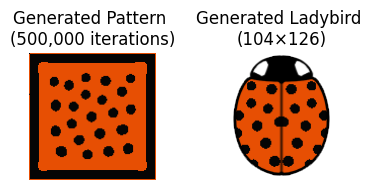

In [16]:
# Display the generated pattern
try:
    pattern_path = os.path.join(dpath_output, 'model_1', f'pattern_{n_iters}.png')
    if os.path.exists(pattern_path):
        print("Loading generated pattern...")
        img_pattern = Image.open(pattern_path)
        
        # Create a figure with subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 2))

        ax1.imshow(img_pattern)
        ax1.set_title(f'Generated Pattern \n({n_iters:,} iterations)', fontsize=12)
        ax1.axis('off')
                
        # Try to load and display the ladybird image
        ladybird_path = os.path.join(dpath_output, 'model_1', f'ladybird_{n_iters}.png')
        if os.path.exists(ladybird_path):
            img_ladybird = Image.open(ladybird_path)
            ax2.imshow(img_ladybird)
            ax2.set_title(f'Generated Ladybird \n({img_ladybird.size[0]}×{img_ladybird.size[1]})', fontsize=12)
            ax2.axis('off')
        else:
            ax2.text(0.5, 0.5, 'Ladybird image\\nnot generated', 
                    ha='center', va='center', transform=ax2.transAxes, fontsize=14)
            ax2.set_title('Ladybird Output', fontsize=12)
            ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
    
        
    else:
        print(f"Pattern file not found at: {pattern_path}")
        print("Available files:", os.listdir(os.path.join(dpath_output, 'model_1')) if os.path.exists(os.path.join(dpath_output, 'model_1')) else "No model_1 directory")
        
except Exception as e:
    print(f"Error loading images: {e}")
    print("This might be normal if the simulation was interrupted or files haven't been generated yet.")
        